# Connection to drive and path definition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/final/SANDS/')
path_files ='/content/drive/MyDrive/Colab Notebooks/final/UC8'

# Import libraries

In [ ]:
!pip install tensorflow==2.12.0

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
import time
from calendar import timegm, monthrange
from datetime import datetime, timedelta
import math
import sands2 as sands
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from os import listdir
from os.path import isfile, join
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import CategoricalAccuracy,Accuracy,BinaryAccuracy


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import ExponentialSmoothing
from scipy.stats import iqr


import json

import nltk
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC




# Data generation or loading

In [ ]:
parameters1 = {
        'time_delta':5
    }

In [ ]:
device_filter = {
    'vendor':'Juniper',
    'role': 'PE'
}

In [ ]:
events_df = sands.generate_events_time_range(datetime.strptime('10/01/22 00:00:01', '%m/%d/%y %H:%M:%S'),datetime.strptime('10/01/22 00:00:01', '%m/%d/%y %H:%M:%S')+timedelta(hours=5),parameters1,"all",with_incidents=True)




In [ ]:
events_df.to_csv(join(path_files,'log_anomaly_detection.csv'))

In [ ]:
events_df=pd.read_csv(join(path_files,'log_anomaly_detection.csv'),index_col=0)

In [ ]:
events_df

,timestamp,event_name,source,fields,severity,message
0,1664582401,very_high_temperature_log,C-1,"[{""device_name"": ""C-1"", ""ip_address"": ""10.2.1....",warning,2022-10-01 00:00:01: %ENVMON-2-IN_OUTLET_OVERT...
402,1664582401,bgp_session_down,tun-1-2-15-2,"[{""device_name"": ""E-1-2"", ""local_address"": ""1....",critical,2022-10-01 00:00:01: bgp_mgr[1463]: %BGP-STATE...
403,1664582401,interface_local_fault,tun-1-2-20-2,"[{""device_name"": ""E-1-2"", ""interface_name"": ""t...",critical,2022-10-01 00:00:01: npu_drvr[9654]: %PLATFORM...
404,1664582401,interface_local_fault,tun-1-2-29-1,"[{""device_name"": ""E-1-2"", ""interface_name"": ""t...",critical,2022-10-01 00:00:01: npu_drvr[2239]: %PLATFORM...
405,1664582401,interface_optics_fault,tun-1-2-30-1,"[{""device_name"": ""E-1-2"", ""interface_name"": ""t...",critical,2022-10-01 00:00:01: lda_server[1679]: %PKT_IN...
...,...,...,...,...,...,...
40773,1664600341,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""11...",info,2022-10-01 04:59:01: bgp_mgr[2294]: %BGP-STATE...
40774,1664600341,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""11...",info,2022-10-01 04:59:01: bgp_mgr[8992]: %BGP-STATE...
40775,1664600341,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""11...",info,2022-10-01 04:59:01: bgp_mgr[3980]: %BGP-STATE...
40777,1664600341,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""12...",info,2022-10-01 04:59:01: bgp_mgr[6973]: %BGP-STATE...


# Data preparation

In [ ]:
log_mask=np.logical_not(events_df['message'].isna())
events_df = events_df[log_mask]

In [ ]:
device_list = []
for i,entry in events_df.iterrows():
  device_name = entry["fields"].split(",")[0].split(":")[1].replace('"','').replace(' ','')
  device_list.append(device_name)
events_df['device']=device_list

<ipython-input-7-6e2e7a1781cb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df['device']=device_list


In [ ]:
events_df

,timestamp,event_name,source,fields,severity,message,device
0,1664582401,very_high_temperature_log,C-1,"[{""device_name"": ""C-1"", ""ip_address"": ""10.2.1....",warning,2022-10-01 00:00:01: %ENVMON-2-IN_OUTLET_OVERT...,C-1
402,1664582401,bgp_session_down,tun-1-2-15-2,"[{""device_name"": ""E-1-2"", ""local_address"": ""1....",critical,2022-10-01 00:00:01: bgp_mgr[1463]: %BGP-STATE...,E-1-2
403,1664582401,interface_local_fault,tun-1-2-20-2,"[{""device_name"": ""E-1-2"", ""interface_name"": ""t...",critical,2022-10-01 00:00:01: npu_drvr[9654]: %PLATFORM...,E-1-2
404,1664582401,interface_local_fault,tun-1-2-29-1,"[{""device_name"": ""E-1-2"", ""interface_name"": ""t...",critical,2022-10-01 00:00:01: npu_drvr[2239]: %PLATFORM...,E-1-2
405,1664582401,interface_optics_fault,tun-1-2-30-1,"[{""device_name"": ""E-1-2"", ""interface_name"": ""t...",critical,2022-10-01 00:00:01: lda_server[1679]: %PKT_IN...,E-1-2
...,...,...,...,...,...,...,...
40773,1664600341,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""11...",info,2022-10-01 04:59:01: bgp_mgr[2294]: %BGP-STATE...,PE-10
40774,1664600341,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""11...",info,2022-10-01 04:59:01: bgp_mgr[8992]: %BGP-STATE...,PE-10
40775,1664600341,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""11...",info,2022-10-01 04:59:01: bgp_mgr[3980]: %BGP-STATE...,PE-10
40777,1664600341,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""12...",info,2022-10-01 04:59:01: bgp_mgr[6973]: %BGP-STATE...,PE-10


In [ ]:
unique_devices = events_df['device'].unique()

In [ ]:
print(len(unique_devices))

304


In [ ]:
for device in unique_devices:
  device_mask = events_df['device']==device
  logs_for_device = events_df.loc[device_mask,"message"]
  next_logs_for_device = list(logs_for_device[1:])
  next_logs_for_device.append('last')
  events_df.at[device_mask,'next_log']=next_logs_for_device


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
events_df

,timestamp,event_name,source,fields,severity,message,device,next_log
0,1664582401,very_high_temperature_log,C-1,"[{""device_name"": ""C-1"", ""ip_address"": ""10.2.1....",warning,2022-10-01 00:00:01: %ENVMON-2-IN_OUTLET_OVERT...,C-1,2022-10-01 00:00:01: npu_drvr[6194]: %PLATFORM...
402,1664582401,bgp_session_down,tun-1-2-15-2,"[{""device_name"": ""E-1-2"", ""local_address"": ""1....",critical,2022-10-01 00:00:01: bgp_mgr[1463]: %BGP-STATE...,E-1-2,2022-10-01 00:00:01: npu_drvr[9654]: %PLATFORM...
403,1664582401,interface_local_fault,tun-1-2-20-2,"[{""device_name"": ""E-1-2"", ""interface_name"": ""t...",critical,2022-10-01 00:00:01: npu_drvr[9654]: %PLATFORM...,E-1-2,2022-10-01 00:00:01: npu_drvr[2239]: %PLATFORM...
404,1664582401,interface_local_fault,tun-1-2-29-1,"[{""device_name"": ""E-1-2"", ""interface_name"": ""t...",critical,2022-10-01 00:00:01: npu_drvr[2239]: %PLATFORM...,E-1-2,2022-10-01 00:00:01: lda_server[1679]: %PKT_IN...
405,1664582401,interface_optics_fault,tun-1-2-30-1,"[{""device_name"": ""E-1-2"", ""interface_name"": ""t...",critical,2022-10-01 00:00:01: lda_server[1679]: %PKT_IN...,E-1-2,2022-10-01 00:00:01: if_mgr[2222]: %INTF-STATE...
...,...,...,...,...,...,...,...,...
40773,1664600341,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""11...",info,2022-10-01 04:59:01: bgp_mgr[2294]: %BGP-STATE...,PE-10,2022-10-01 04:59:01: bgp_mgr[8992]: %BGP-STATE...
40774,1664600341,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""11...",info,2022-10-01 04:59:01: bgp_mgr[8992]: %BGP-STATE...,PE-10,2022-10-01 04:59:01: bgp_mgr[3980]: %BGP-STATE...
40775,1664600341,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""11...",info,2022-10-01 04:59:01: bgp_mgr[3980]: %BGP-STATE...,PE-10,2022-10-01 04:59:01: bgp_mgr[6973]: %BGP-STATE...
40777,1664600341,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""12...",info,2022-10-01 04:59:01: bgp_mgr[6973]: %BGP-STATE...,PE-10,last


In [ ]:
not_last_mask = events_df['next_log']!='last'
events_df = events_df[not_last_mask]

In [ ]:
events_df

,timestamp,event_name,source,fields,severity,message,device,next_log
0,1664582401,very_high_temperature_log,C-1,"[{""device_name"": ""C-1"", ""ip_address"": ""10.2.1....",warning,2022-10-01 00:00:01: %ENVMON-2-IN_OUTLET_OVERT...,C-1,2022-10-01 00:00:01: npu_drvr[6194]: %PLATFORM...
402,1664582401,bgp_session_down,tun-1-2-15-2,"[{""device_name"": ""E-1-2"", ""local_address"": ""1....",critical,2022-10-01 00:00:01: bgp_mgr[1463]: %BGP-STATE...,E-1-2,2022-10-01 00:00:01: npu_drvr[9654]: %PLATFORM...
403,1664582401,interface_local_fault,tun-1-2-20-2,"[{""device_name"": ""E-1-2"", ""interface_name"": ""t...",critical,2022-10-01 00:00:01: npu_drvr[9654]: %PLATFORM...,E-1-2,2022-10-01 00:00:01: npu_drvr[2239]: %PLATFORM...
404,1664582401,interface_local_fault,tun-1-2-29-1,"[{""device_name"": ""E-1-2"", ""interface_name"": ""t...",critical,2022-10-01 00:00:01: npu_drvr[2239]: %PLATFORM...,E-1-2,2022-10-01 00:00:01: lda_server[1679]: %PKT_IN...
405,1664582401,interface_optics_fault,tun-1-2-30-1,"[{""device_name"": ""E-1-2"", ""interface_name"": ""t...",critical,2022-10-01 00:00:01: lda_server[1679]: %PKT_IN...,E-1-2,2022-10-01 00:00:01: if_mgr[2222]: %INTF-STATE...
...,...,...,...,...,...,...,...,...
40776,1664600341,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""12...",info,2022-10-01 04:59:01: bgp_mgr[5966]: %BGP-STATE...,PE-10,2022-10-01 04:59:01: bgp_mgr[7311]: %BGP-STATE...
40772,1664600341,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""11...",info,2022-10-01 04:59:01: bgp_mgr[7311]: %BGP-STATE...,PE-10,2022-10-01 04:59:01: bgp_mgr[2294]: %BGP-STATE...
40773,1664600341,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""11...",info,2022-10-01 04:59:01: bgp_mgr[2294]: %BGP-STATE...,PE-10,2022-10-01 04:59:01: bgp_mgr[8992]: %BGP-STATE...
40774,1664600341,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""11...",info,2022-10-01 04:59:01: bgp_mgr[8992]: %BGP-STATE...,PE-10,2022-10-01 04:59:01: bgp_mgr[3980]: %BGP-STATE...


In [ ]:
log_list = events_df['message'].to_list()
next_log_list = events_df['next_log'].to_list()

In [ ]:
log_list[45:60]

['2022-10-01 00:00:01: if_mgr[4765]: %INTF-STATE_MGR-3-STATE_CHANGE_EVENT : Interface changed state to down: tun-1-1 in device E-23-1',
 '2022-10-01 00:00:01: if_mgr[4693]: %INTF-STATE_MGR-3-STATE_CHANGE_EVENT : Interface changed state to down: tun-100-1 in device E-30-2',
 '2022-10-01 00:00:01: if_mgr[7679]: %INTF-STATE_MGR-3-STATE_CHANGE_EVENT : Interface changed state to up: et-1-1-1 in device E-31-2',
 '2022-10-01 00:00:01: bgp_mgr[506]: %BGP-STATE_MGR-3-STATE_CHANGE_EVENT : BGP session to 12.32.1.1/30 changed state to down in device E-32-1',
 '2022-10-01 00:00:01: bgp_mgr[8021]: %BGP-STATE_MGR-3-STATE_CHANGE_EVENT : BGP session to 37.1.1.11/30 changed state to down in device E-37-1',
 '2022-10-01 00:00:01: if_mgr[3564]: %INTF-STATE_MGR-3-STATE_CHANGE_EVENT : Interface changed state to up: tun-1-2 in device E-37-1',
 '2022-10-01 00:00:01: if_mgr[1133]: %INTF-STATE_MGR-3-STATE_CHANGE_EVENT : Interface changed state to down: et-1-1-1 in device E-38-2',
 '2022-10-01 00:00:01: if_mgr[2

In [ ]:
len(log_list)

39263

In [ ]:
max_log_len = 0
log_lens = []
for log in log_list:
  log_lens.append(len(log))
  if len(log)>max_log_len:
    max_log_len = len(log)
max_log_len

208

Text(0.5, 0, 'Data')

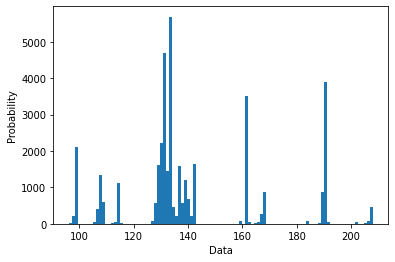

In [ ]:
plt.hist(log_lens, bins=100)
plt.ylabel('Probability')
plt.xlabel('Data')

In [ ]:
max_len = max_log_len


In [ ]:
training_logs_c = []
label_logs_c = []
for i in range(len(log_list)):
  training_logs_c.append([char for char in log_list[i]])
  label_logs_c.append([char for char in next_log_list[i]])


In [ ]:
total_text = []
for log in training_logs_c:
  total_text += log
c_vocab = set(total_text)
len(c_vocab)

68

In [ ]:
c_vocab = list(c_vocab)

In [ ]:
c_indexes =[*range(0,len(c_vocab),1)]

In [ ]:
c_n_dict = dict(zip(c_vocab,c_indexes))
n_c_dict = dict(zip(c_indexes,c_vocab))

In [ ]:
with open(join(path_files,'c_n_dict_pred.txt'), 'w') as outfile:
    json.dump(c_n_dict, outfile)

with open(join(path_files,'n_c_dict_pred.txt'), 'w') as outfile:
    json.dump(n_c_dict, outfile)

In [ ]:
with open(join(path_files,'c_n_dict_pred.txt'), 'r') as infile:
    c_n_dict=json.load(infile)

with open(join(path_files,'n_c_dict_pred.txt'), 'r') as infile:
    n_c_dict=json.load(infile)
n_c_dict = { int(key):value for key,value in n_c_dict.items()}

In [ ]:
n_c_dict[21]

'k'

In [ ]:
c_n_dict['k']

21

In [ ]:
def log_encode(loglist):
  log_array=np.zeros((len(log_list),max_len))
  for i in range(len(loglist)):
    log = loglist[i]
    log_n = [c_n_dict[c] for c in log]
    log_n += [c_n_dict[' ']]*(max_len-len(log_n))
    log_array[i,:]=log_n
  return log_array

In [ ]:
training_array = log_encode(training_logs_c)
labels_array = log_encode(label_logs_c)

In [ ]:
training_array.shape

(39263, 208)

In [ ]:
training_size = 20000
testing_size = 2000
total_subset = training_size+testing_size

In [ ]:
def binarize_array(log_array):
  training_array_b=np.zeros((total_subset,max_len,len(c_vocab)))
  for i in range(training_array_b.shape[0]):
    for j in range(training_array_b.shape[1]):
        training_array_b[i,j,int(log_array[i,j])]=1
  return training_array_b



In [ ]:
training_array_b = binarize_array(training_array)
labels_array_b = binarize_array(labels_array)

In [ ]:
training_array_b.shape

(22000, 208, 68)

In [ ]:
X_train=training_array_b[:training_size,:,:]
y_train=labels_array_b[:training_size,:,:]
X_test=training_array_b[training_size:,:,:]
y_test=labels_array_b[training_size:,:,:]


In [ ]:
training_array = []
labels_array = []
training_array_b = []
labels_array_b = []

# Model definition and training

In [ ]:
mymodel = tf.keras.Sequential()
mymodel.add(Bidirectional(LSTM(256, return_sequences=True,recurrent_dropout=0.1),input_shape=(max_len, len(c_vocab),)))
mymodel.add(Bidirectional(LSTM(128,return_sequences=True,recurrent_dropout=0.1)))
mymodel.add(layers.TimeDistributed(Dense(len(c_vocab),activation='softmax')))
mymodel.add(layers.Dropout(0.1))

In [ ]:
mymodel.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 208, 512)         665600    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 208, 256)         656384    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 208, 68)          17476     
 ibuted)                                                         
                                                                 
 dropout_9 (Dropout)         (None, 208, 68)           0         
                                                                 
Total params: 1,339,460
Trainable params: 1,339,460
Non-trainable params: 0
____________________________________________

In [ ]:
mymodel.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [ ]:
filepath=join(path_files,"weights_lstm_next_log_prediction_best.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
mymodel.load_weights(filepath)

In [ ]:
history = mymodel.fit(X_train,y_train,batch_size=128,epochs=40,validation_data=(X_test,y_test),callbacks=callbacks_list,verbose=1)


Epoch 1/40
 72/157 [============>.................] - ETA: 3:07 - loss: 2.6301 - categorical_accuracy: 0.5725

KeyboardInterrupt: ignored

# Results evaluation

In [ ]:
score, acc = mymodel.evaluate(X_test, y_test)

63/63 [==============================] - 20s 311ms/step - loss: 1.1974 - categorical_accuracy: 0.6208


In [ ]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 1.1973886489868164
Test accuracy: 0.6208245158195496


In [ ]:
y_pred = mymodel.predict(X_test)

63/63 [==============================] - 20s 303ms/step


In [ ]:
y_train_pred = mymodel.predict(X_train)

625/625 [==============================] - 190s 304ms/step


In [ ]:
def print_log(binarized_log):
  max_value_index = np.argmax(binarized_log,axis=-1)
  new_logs = []
  for i in range(binarized_log.shape[0]):
    char_list = [n_c_dict[j] for j in max_value_index[i]]
    new_log =''.join(char_list)
    print('Log message: ',new_log)
    new_logs.append(new_log)
  return new_logs

In [ ]:
def binarize_log(generated_log):
  binarized_log = np.zeros(generated_log.shape)
  for i in range(generated_log.shape[0]):
    for j in range(generated_log.shape[1]):
      max_value = np.max(generated_log[i,j])
      binarized_log[i,j,:]=np.where(generated_log[i,j,:]==max_value,1,0)
  return binarized_log

In [ ]:
y_pred_b = binarize_log(y_pred)

In [ ]:
y_train_pred_b = binarize_log(y_train_pred)

In [ ]:
print_log(y_train_pred_b[20:21])

Log message:  2022-10-01 00:00:01: if_mgr[[[r[]: %INTF-STATE_MGR-3-STATE_CHANGE_EVENT : Interface changed state to down: et-1-1-  in device  E--                                                                              


['2022-10-01 00:00:01: if_mgr[[[r[]: %INTF-STATE_MGR-3-STATE_CHANGE_EVENT : Interface changed state to down: et-1-1-  in device  E--                                                                              ']

In [ ]:
print_log(y_train[20:21])

Log message:  2022-10-01 00:00:01: if_mgr[6887]: %INTF-STATE_MGR-3-STATE_CHANGE_EVENT : Interface changed state to down: et-1-1-4 in device PE-99                                                                             


['2022-10-01 00:00:01: if_mgr[6887]: %INTF-STATE_MGR-3-STATE_CHANGE_EVENT : Interface changed state to down: et-1-1-4 in device PE-99                                                                             ']

In [ ]:
def find_accuracy(y_test,y_pred):
  length = y_test.shape[1]
  accurate_pred = np.zeros(length)
  total_pred = y_test.shape[0]
  for i in range(y_test.shape[0]):
    for j in range(length):
      if np.array_equal(y_test[i,j,:],y_pred[i,j,:]):
        accurate_pred[j] +=1
  accurate_pred = accurate_pred / total_pred
  return accurate_pred





In [ ]:
accurate_pred = find_accuracy(y_train,y_train_pred_b)

Text(0.5, 1.0, 'Log prediction accuracy vs character position in log')

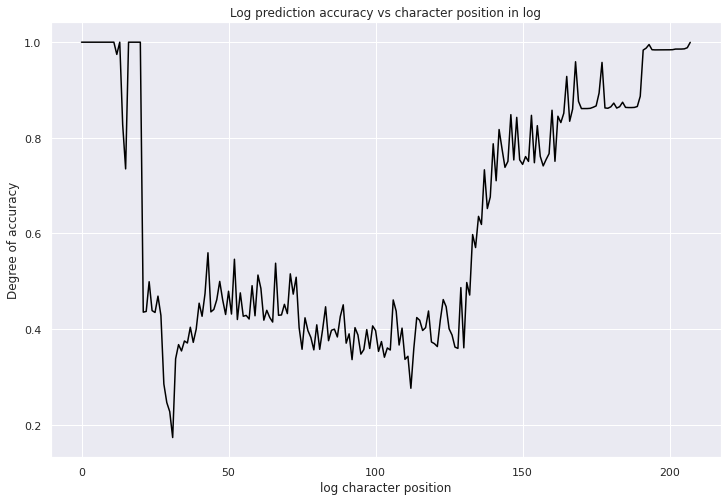

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=range(len(accurate_pred)), y=accurate_pred,color='black')
plt.xlabel('log character position')
plt.ylabel('Degree of accuracy')
plt.title('Log prediction accuracy vs character position in log')

In [ ]:
accurate_test_pred = find_accuracy(y_test,y_pred_b)

Text(0.5, 1.0, 'Log prediction accuracy vs character position in log')

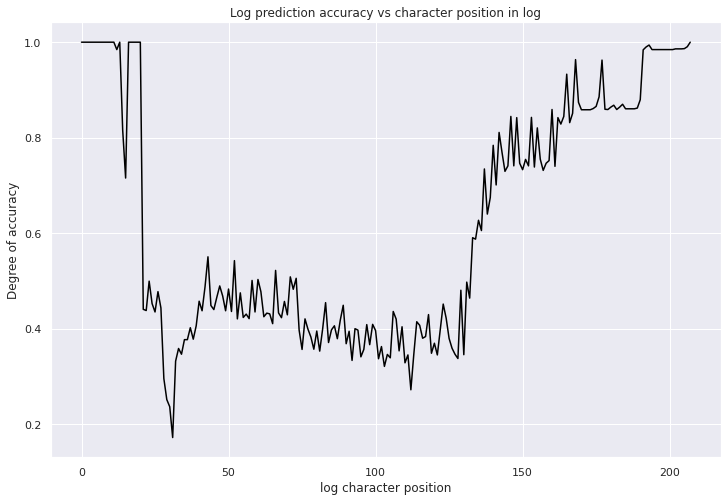

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=range(len(accurate_test_pred)), y=accurate_test_pred,color='black')
plt.xlabel('log character position')
plt.ylabel('Degree of accuracy')
plt.title('Log prediction accuracy vs character position in log')